#### Data & Modules Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install mne
! pip install neurodsp
! pip install -U mne-connectivity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00


In [126]:
import os
import cmath
import mne
import mne_connectivity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.projections.polar import PolarAxes
import seaborn as sns
import neurodsp as ndsp
from neurodsp import spectral

from sklearn.cross_decomposition import CCA
from scipy.signal import coherence

mne.set_log_level('ERROR')

In [4]:
pre_dir = "/content/drive/My Drive/TBI_data/pre_retreat/"
post_dir = "/content/drive/My Drive/TBI_data/post_retreat/"

In [5]:
pre_raw = [mne.io.read_raw_edf(pre_dir+file, preload=True) for file in os.listdir(pre_dir)]
post_raw = [mne.io.read_raw_edf(post_dir+file, preload=True) for file in os.listdir(post_dir)]

In [6]:
len(pre_raw), len(post_raw)

(21, 21)

#### Extract Last 7 Seconds Of EEG Data

<ipython-input-7-ce5c25c32742>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pre_durations, kde=True, label='pre_retreat recordings')
<ipython-input-7-ce5c25c32742>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(post_durations, kde=True, label='post_retreat recordings')


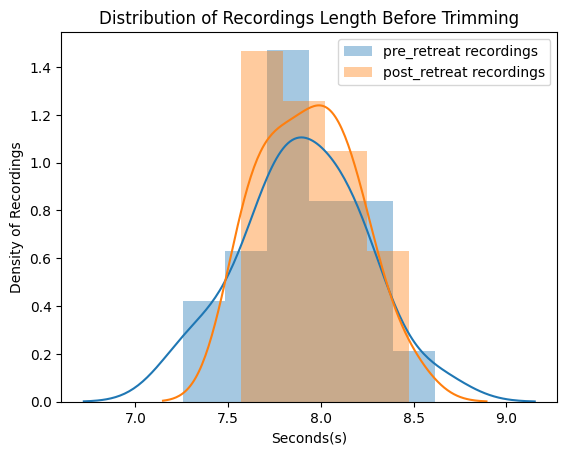

In [7]:
pre_durations = [raw.n_times/(raw.info["sfreq"]*60) for raw in pre_raw]
post_durations = [raw.n_times/(raw.info["sfreq"]*60) for raw in post_raw]

# Histogram and KDE for pre_retreat
sns.distplot(pre_durations, kde=True, label='pre_retreat recordings')

# Histogram and KDE for post_retreat
sns.distplot(post_durations, kde=True, label='post_retreat recordings')

# Add labels and title
plt.xlabel('Seconds(s)')
plt.ylabel('Density of Recordings')
plt.title('Distribution of Recordings Length Before Trimming')
plt.legend()

# Show the plot
plt.show()

In [8]:
t_d = 15
pre_raw = [raw.crop(tmin=0,tmax=(raw.n_times/raw.info["sfreq"])-int(t_d/2)) for raw in pre_raw]
post_raw = [raw.crop(tmin=0,tmax=(raw.n_times/raw.info["sfreq"])-t_d) for raw in post_raw]

In [9]:
pre_raw = [raw.crop(tmin=raw.times[-1] - 7*60) if raw.n_times/(raw.info["sfreq"]*60)>7 else raw for raw in pre_raw]
post_raw = [raw.crop(tmin=raw.times[-1] - 7*60) if raw.n_times/(raw.info["sfreq"]*60)>7 else raw for raw in post_raw]

<ipython-input-10-d18290e1a210>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pre_durations, kde=True, label='pre_retreat recordings')
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-10-d18290e1a210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function fo

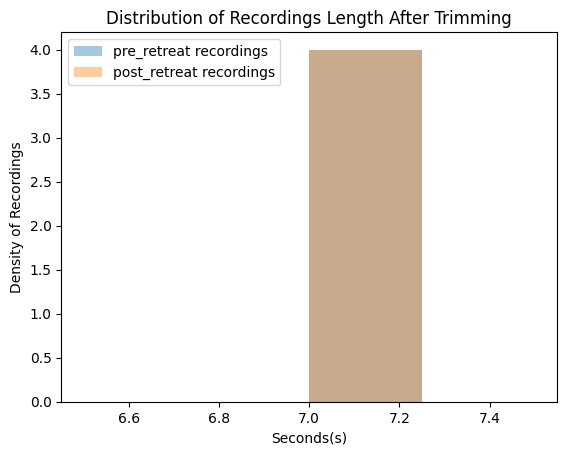

In [10]:
pre_durations = [raw.n_times/(raw.info["sfreq"]*60) for raw in pre_raw]
post_durations = [raw.n_times/(raw.info["sfreq"]*60) for raw in post_raw]

# Histogram and KDE for pre_retreat
sns.distplot(pre_durations, kde=True, label='pre_retreat recordings')

# Histogram and KDE for post_retreat
sns.distplot(post_durations, kde=True, label='post_retreat recordings')

# Add labels and title
plt.xlabel('Seconds(s)')
plt.ylabel('Density of Recordings')
plt.title('Distribution of Recordings Length After Trimming')
plt.legend()

# Show the plot
plt.show()

#### Add Electrode Montage to Recordings

In [11]:
drop_channels = ["Trigger","EEG CM-Pz","EEG X3-Pz","EEG X2-Pz","EEG X1-Pz"]

pre_raw = [raw.drop_channels(drop_channels) for raw in pre_raw]
post_raw = [raw.drop_channels(drop_channels) for raw in post_raw]

In [12]:
# Given channel names
channel_names = [
    'EEG P3-Pz', 'EEG C3-Pz', 'EEG F3-Pz', 'EEG Fz-Pz', 'EEG F4-Pz',
    'EEG C4-Pz', 'EEG P4-Pz', 'EEG Cz-Pz', 'EEG A1-Pz',
    'EEG Fp1-Pz', 'EEG Fp2-Pz', 'EEG T3-Pz', 'EEG T5-Pz', 'EEG O1-Pz',
    'EEG O2-Pz', 'EEG F7-Pz', 'EEG F8-Pz', 'EEG A2-Pz', 'EEG T6-Pz', 'EEG T4-Pz'
]

# Extract electrode names
electrode_name = lambda name: name.split()[1].split('-')[0]

# Standard 10-20 system coordinates (example for known electrodes)
ten_twenty_coords = mne.channels.make_standard_montage('standard_1020').get_positions()['ch_pos']

# Coordinates dictionary
coords = {}

# Define coordinates for known electrodes
for electrode in channel_names:
    electrode_ = electrode_name(electrode)
    if electrode_ in ten_twenty_coords:
        coords[electrode] = ten_twenty_coords[electrode_]

# Define coordinates for custom electrodes (X1, X2, X3, CM)
# Here we assign arbitrary coordinates or estimate positions
coords['X1'] = np.array([0, 0, 0])
coords['X2'] = np.array([0, 0, 0])
coords['X3'] = np.array([0, 0, 0])
coords['CM'] = np.array([0, 0, 0])  # Example coordinate

# Create montage
montage = mne.channels.make_dig_montage(ch_pos=coords)

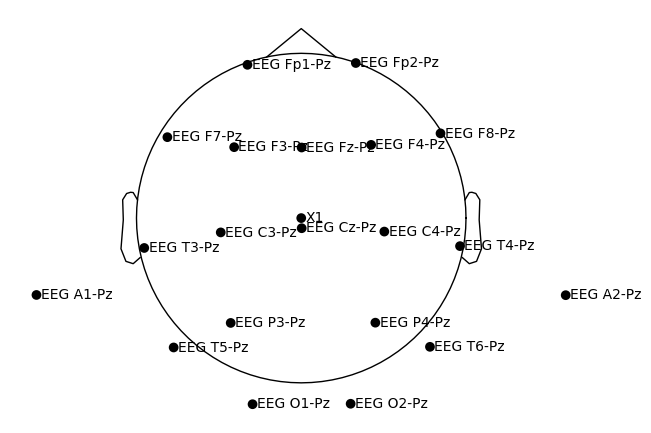

In [13]:
montage.plot()
plt.close("all")

In [14]:
pre_raw = [raw.set_montage(montage) for raw in pre_raw]
post_raw = [raw.set_montage(montage) for raw in post_raw]

#### Preprocessing of EEG Data

In [15]:
len(pre_raw), len(post_raw)

(21, 21)

In [16]:
post_lowcuts = [raw.info["lowpass"] for raw in post_raw]
pre_lowcuts = [raw.info["lowpass"] for raw in pre_raw]

post_highcuts = [raw.info["highpass"] for raw in post_raw]
pre_highcuts = [raw.info["highpass"] for raw in pre_raw]

post_linefreq = [raw.info["line_freq"] if raw.info["line_freq"]!=None else 0 for raw in post_raw]
pre_linefreq = [raw.info["line_freq"] if raw.info["line_freq"]!=None else 0 for raw in pre_raw]

post_sfreq = [raw.info["sfreq"] for raw in post_raw]
pre_sfreq = [raw.info["sfreq"] for raw in pre_raw]

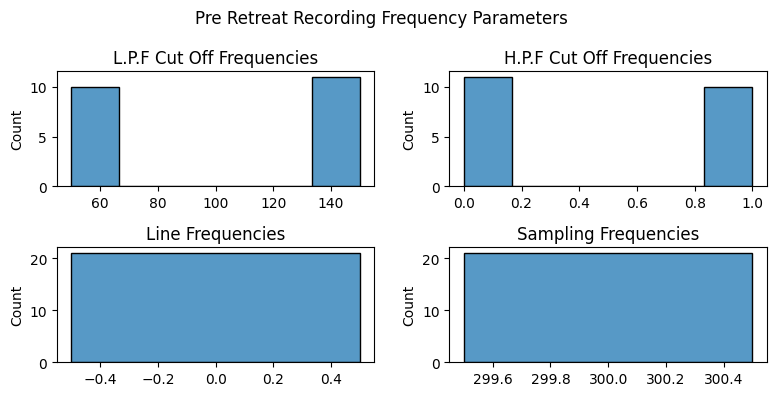

In [17]:
fig_, ax_ = plt.subplots(2, 2, figsize=(8,4))

sns.histplot(pre_lowcuts, ax=ax_[0,0])
ax_[0,0].set_title("L.P.F Cut Off Frequencies")

sns.histplot(pre_highcuts, ax=ax_[0,1])
ax_[0,1].set_title("H.P.F Cut Off Frequencies")

sns.histplot(pre_linefreq, ax=ax_[1,0])
ax_[1,0].set_title("Line Frequencies")

sns.histplot(pre_sfreq, ax=ax_[1,1])
ax_[1,1].set_title("Sampling Frequencies")

fig_.suptitle("Pre Retreat Recording Frequency Parameters")
fig_.tight_layout()

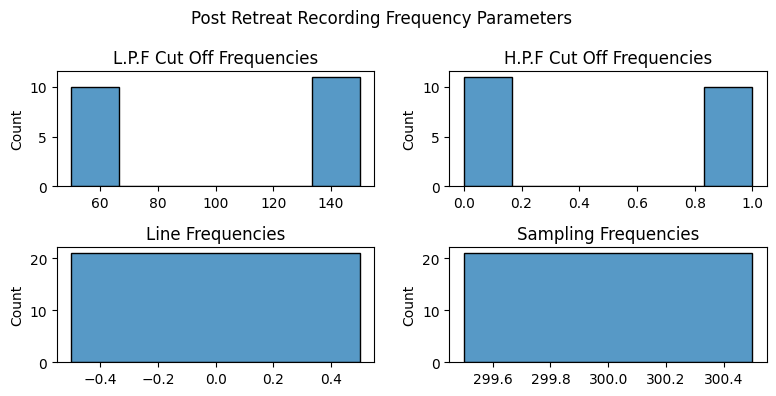

In [18]:
fig_, ax_ = plt.subplots(2, 2, figsize=(8,4))

sns.histplot(post_lowcuts, ax=ax_[0,0])
ax_[0,0].set_title("L.P.F Cut Off Frequencies")

sns.histplot(post_highcuts, ax=ax_[0,1])
ax_[0,1].set_title("H.P.F Cut Off Frequencies")

sns.histplot(post_linefreq, ax=ax_[1,0])
ax_[1,0].set_title("Line Frequencies")

sns.histplot(post_sfreq, ax=ax_[1,1])
ax_[1,1].set_title("Sampling Frequencies")

fig_.suptitle("Post Retreat Recording Frequency Parameters")
fig_.tight_layout()

In [19]:
fmin_, fmax_ = 1, 150

<ipython-input-20-b4d017b520df>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_.tight_layout()


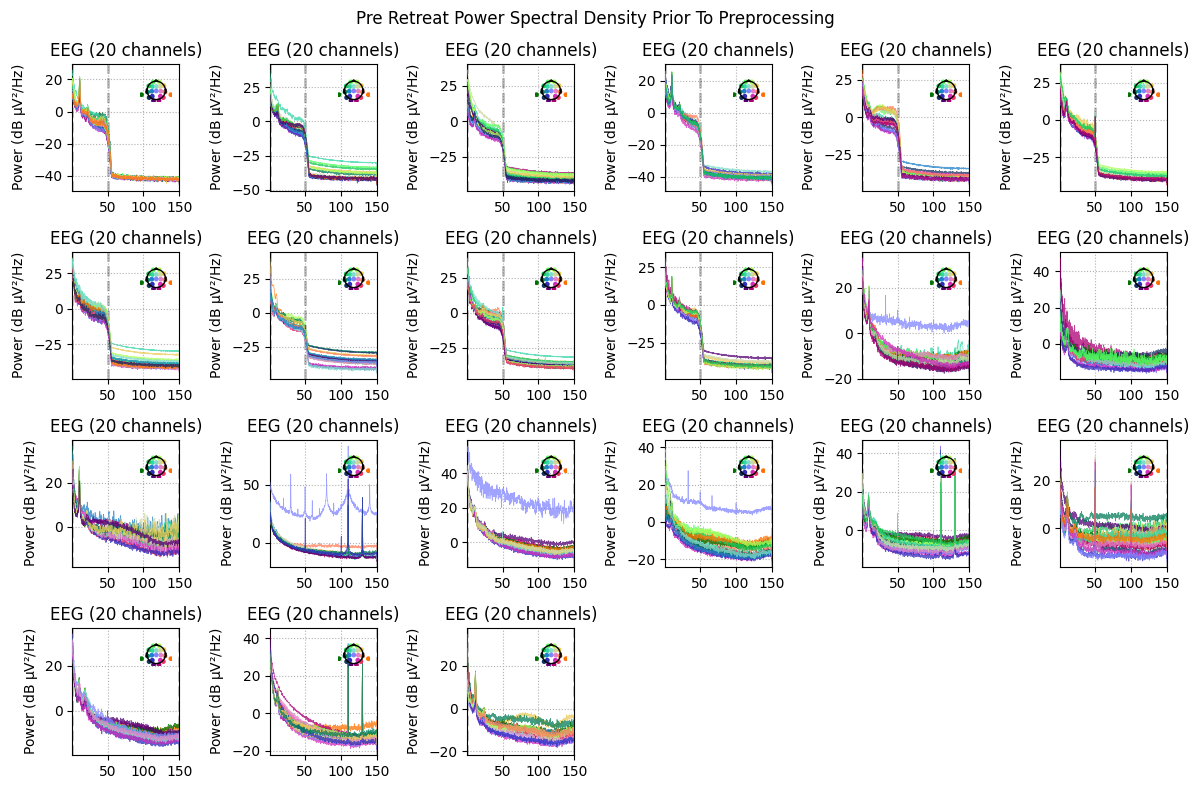

In [20]:
fig_, ax_ = plt.subplots(4, 6, figsize=(12,8))

for r in range(ax_.flatten().shape[0]):
    if r<len(pre_raw):
        pre_raw[r].plot_psd(fmin=fmin_, fmax=fmax_, ax=ax_.flatten()[r])
    elif r>=len(pre_raw):
        ax_.flatten()[r].set_visible(False)

fig_.suptitle("Pre Retreat Power Spectral Density Prior To Preprocessing")
fig_.tight_layout()

<ipython-input-21-07791613eed4>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_.tight_layout()


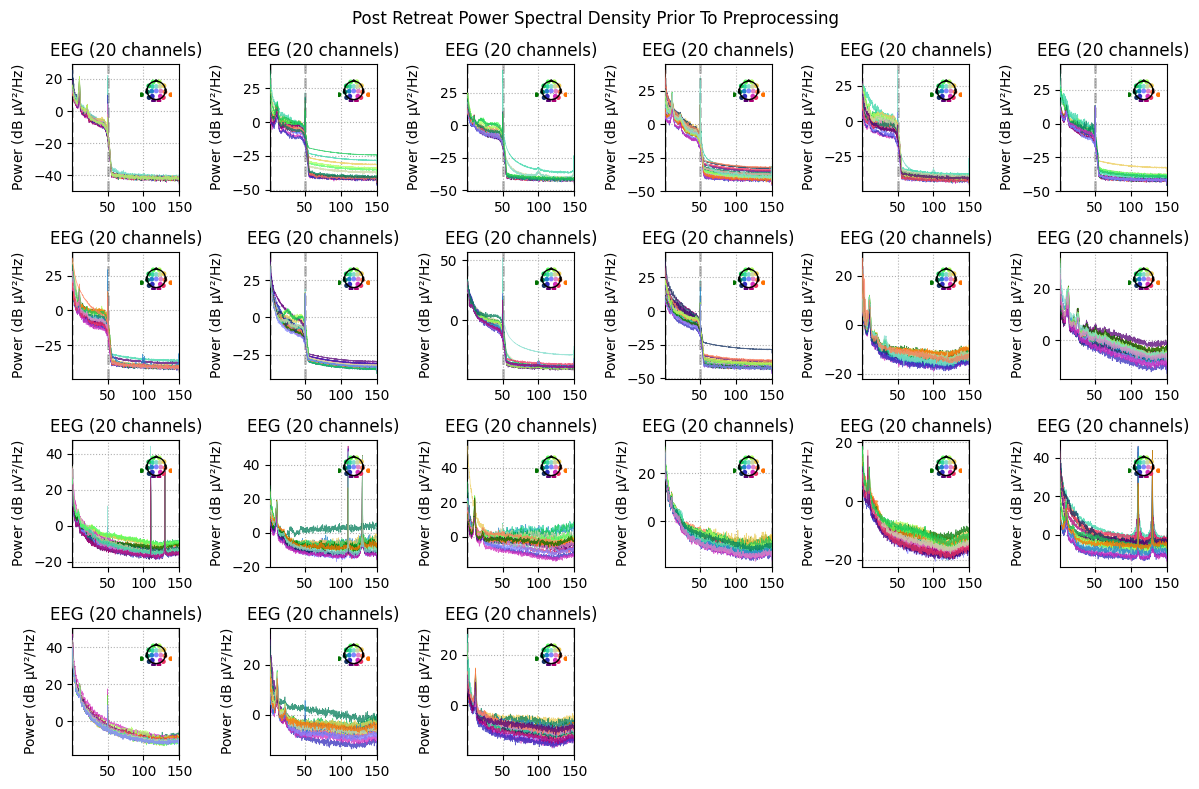

In [21]:
fig_, ax_ = plt.subplots(4, 6, figsize=(12,8))

for r in range(ax_.flatten().shape[0]):
    if r<len(post_raw):
        post_raw[r].plot_psd(fmin=fmin_, fmax=fmax_, ax=ax_.flatten()[r])
    elif r>=len(post_raw):
        ax_.flatten()[r].set_visible(False)

fig_.suptitle("Post Retreat Power Spectral Density Prior To Preprocessing")
fig_.tight_layout()

In [22]:
lcut, hcut = 1, 35

pre_raw = [raw.filter(l_freq=lcut, h_freq=hcut) for raw in pre_raw]
post_raw = [raw.filter(l_freq=lcut, h_freq=hcut) for raw in post_raw]

<ipython-input-23-f5cc8b2f1d56>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_.tight_layout()


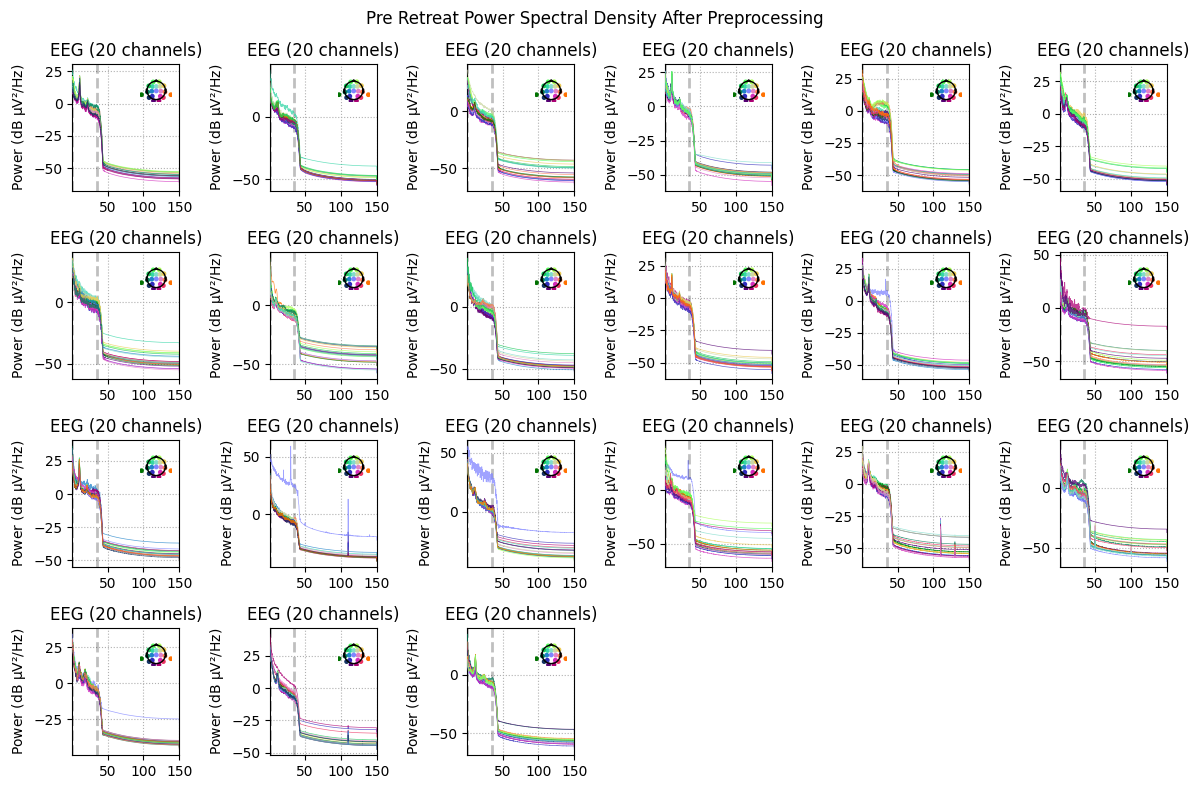

In [23]:
fig_, ax_ = plt.subplots(4, 6, figsize=(12,8))

for r in range(ax_.flatten().shape[0]):
    if r<len(pre_raw):
        pre_raw[r].plot_psd(fmin=fmin_, fmax=fmax_, ax=ax_.flatten()[r])
    elif r>=len(pre_raw):
        ax_.flatten()[r].set_visible(False)

fig_.suptitle("Pre Retreat Power Spectral Density After Preprocessing")
fig_.tight_layout()

<ipython-input-24-5387d28ce807>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_.tight_layout()


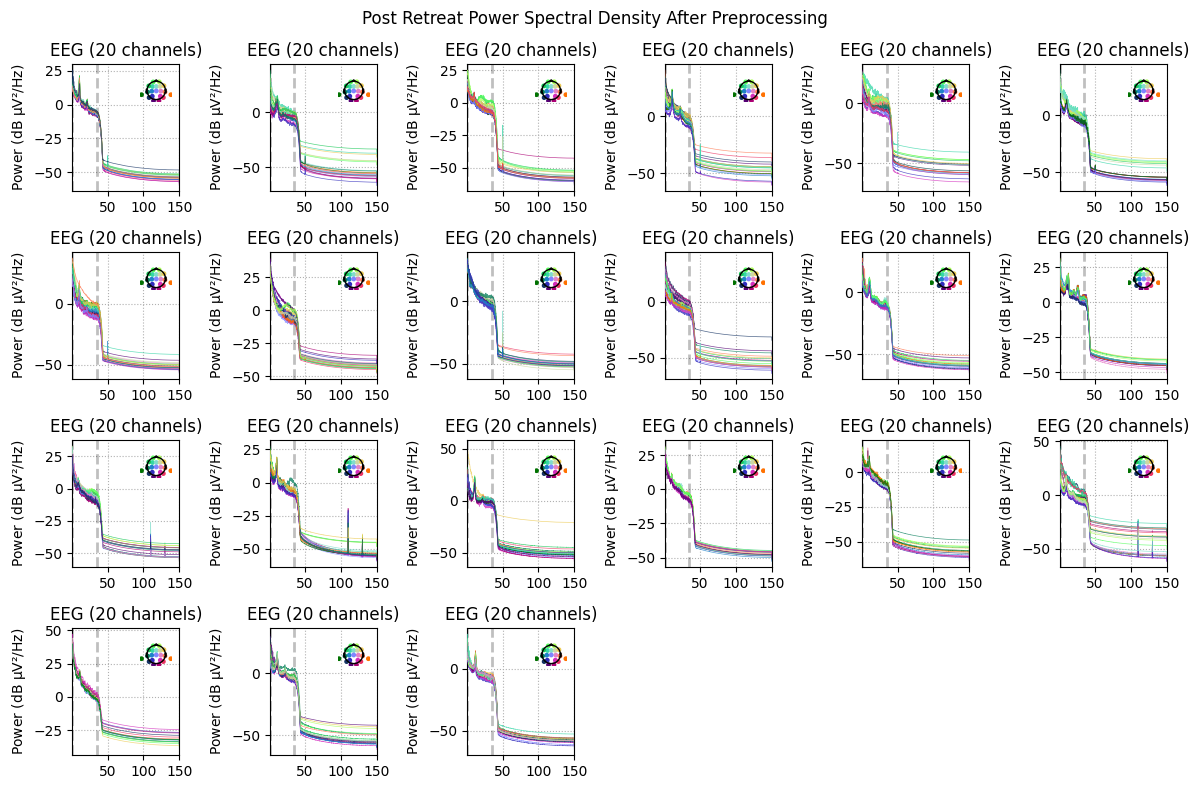

In [24]:
fig_, ax_ = plt.subplots(4, 6, figsize=(12,8))

for r in range(ax_.flatten().shape[0]):
    if r<len(post_raw):
        post_raw[r].plot_psd(fmin=fmin_, fmax=fmax_, ax=ax_.flatten()[r])
    elif r>=len(post_raw):
        ax_.flatten()[r].set_visible(False)

fig_.suptitle("Post Retreat Power Spectral Density After Preprocessing")
fig_.tight_layout()

## Features Computation & Analysis

In [25]:
channels = pre_raw[0].ch_names
channels = map(electrode_name, channels)
channels = list(channels)

len(channels)

20

In [26]:
delta = [1, 4]
theta = [4, 8]
alpha = [8, 12]
beta = [12, 30]

fs = pre_raw[0].info['sfreq']

In [27]:
preretreat = np.array([raw.get_data() for raw in pre_raw])
postretreat = np.array([raw.get_data() for raw in post_raw])
preretreat.shape, postretreat.shape

((21, 20, 126001), (21, 20, 126001))

### Bands Power

In [28]:
pre_retreat_psds = []
post_retreat_psds = []

for s, s_eeg in enumerate(preretreat):
    freqs, spectrum = spectral.compute_spectrum_welch(s_eeg,fs)
    pre_retreat_psds.append(spectrum)
for s, s_eeg in enumerate(postretreat):
    freqs, spectrum = spectral.compute_spectrum_welch(s_eeg,fs)
    post_retreat_psds.append(spectrum)

pre_retreat_psds = np.array(pre_retreat_psds)
post_retreat_psds = np.array(post_retreat_psds)

pre_retreat_psds = (pre_retreat_psds - pre_retreat_psds.min()) / (pre_retreat_psds.max() - pre_retreat_psds.min())
post_retreat_psds = (post_retreat_psds - post_retreat_psds.min()) / (post_retreat_psds.max() - post_retreat_psds.min())

psd_freqs = freqs
pre_retreat_psds.shape, post_retreat_psds.shape

((21, 20, 151), (21, 20, 151))

In [29]:
# pre-retreat Bands Power

delta_index = np.argwhere((psd_freqs>=delta[0]) & (psd_freqs<=delta[1]))
theta_index = np.argwhere((psd_freqs>=theta[0]) & (psd_freqs<=theta[1]))
alpha_index = np.argwhere((psd_freqs>=alpha[0]) & (psd_freqs<=alpha[1]))
beta_index = np.argwhere((psd_freqs>=beta[0]) & (psd_freqs<=beta[1]))

delta_band_power = np.mean(pre_retreat_psds[:,:,delta_index].squeeze(), axis=-1)
theta_band_power = np.mean(pre_retreat_psds[:,:,theta_index].squeeze(), axis=-1)
alpha_band_power = np.mean(pre_retreat_psds[:,:,alpha_index].squeeze(), axis=-1)
beta_band_power = np.mean(pre_retreat_psds[:,:,beta_index].squeeze(), axis=-1)

delta_band_power = pd.DataFrame(delta_band_power, columns=[ch + "-δ" for ch in channels])
theta_band_power = pd.DataFrame(theta_band_power, columns=[ch + "-θ" for ch in channels])
alpha_band_power = pd.DataFrame(alpha_band_power, columns=[ch + "-ɑ" for ch in channels])
beta_band_power = pd.DataFrame(beta_band_power, columns=[ch + "-β" for ch in channels])

pre_retreat_bands_power = pd.concat([delta_band_power, theta_band_power, alpha_band_power, beta_band_power], axis=1)

In [30]:
# post-retreat Bands Power

delta_index = np.argwhere((psd_freqs>=delta[0]) & (psd_freqs<=delta[1]))
theta_index = np.argwhere((psd_freqs>=theta[0]) & (psd_freqs<=theta[1]))
alpha_index = np.argwhere((psd_freqs>=alpha[0]) & (psd_freqs<=alpha[1]))
beta_index = np.argwhere((psd_freqs>=beta[0]) & (psd_freqs<=beta[1]))

delta_band_power = np.mean(post_retreat_psds[:,:,delta_index].squeeze(), axis=-1)
theta_band_power = np.mean(post_retreat_psds[:,:,theta_index].squeeze(), axis=-1)
alpha_band_power = np.mean(post_retreat_psds[:,:,alpha_index].squeeze(), axis=-1)
beta_band_power = np.mean(post_retreat_psds[:,:,beta_index].squeeze(), axis=-1)

delta_band_power = pd.DataFrame(delta_band_power, columns=[ch + "-δ" for ch in channels])
theta_band_power = pd.DataFrame(theta_band_power, columns=[ch + "-θ" for ch in channels])
alpha_band_power = pd.DataFrame(alpha_band_power, columns=[ch + "-ɑ" for ch in channels])
beta_band_power = pd.DataFrame(beta_band_power, columns=[ch + "-β" for ch in channels])

post_retreat_bands_power = pd.concat([delta_band_power, theta_band_power, alpha_band_power, beta_band_power], axis=1)

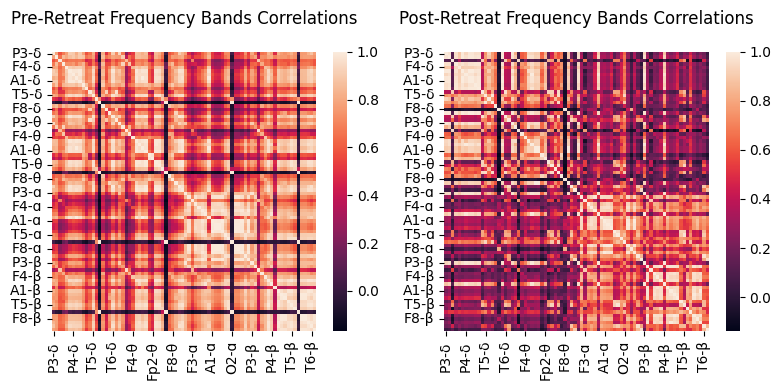

In [31]:
fig_, ax_ = plt.subplots(1, 2, figsize=(8,4))

sns.heatmap(pre_retreat_bands_power.corr(), ax=ax_[0])
ax_[0].set_title("Pre-Retreat Frequency Bands Correlations", pad=20)

sns.heatmap(post_retreat_bands_power.corr(), ax=ax_[1])
ax_[1].set_title("Post-Retreat Frequency Bands Correlations", pad=20)

fig_.tight_layout()

In [32]:
X = pre_retreat_bands_power
Y = post_retreat_bands_power

X -= X.mean(axis=0)
Y -= Y.mean(axis=0)

In [33]:
bands_power_CCA = CCA(n_components=20, scale=True)
bands_power_CCA.fit(X,Y)

CCA(n_components=20)

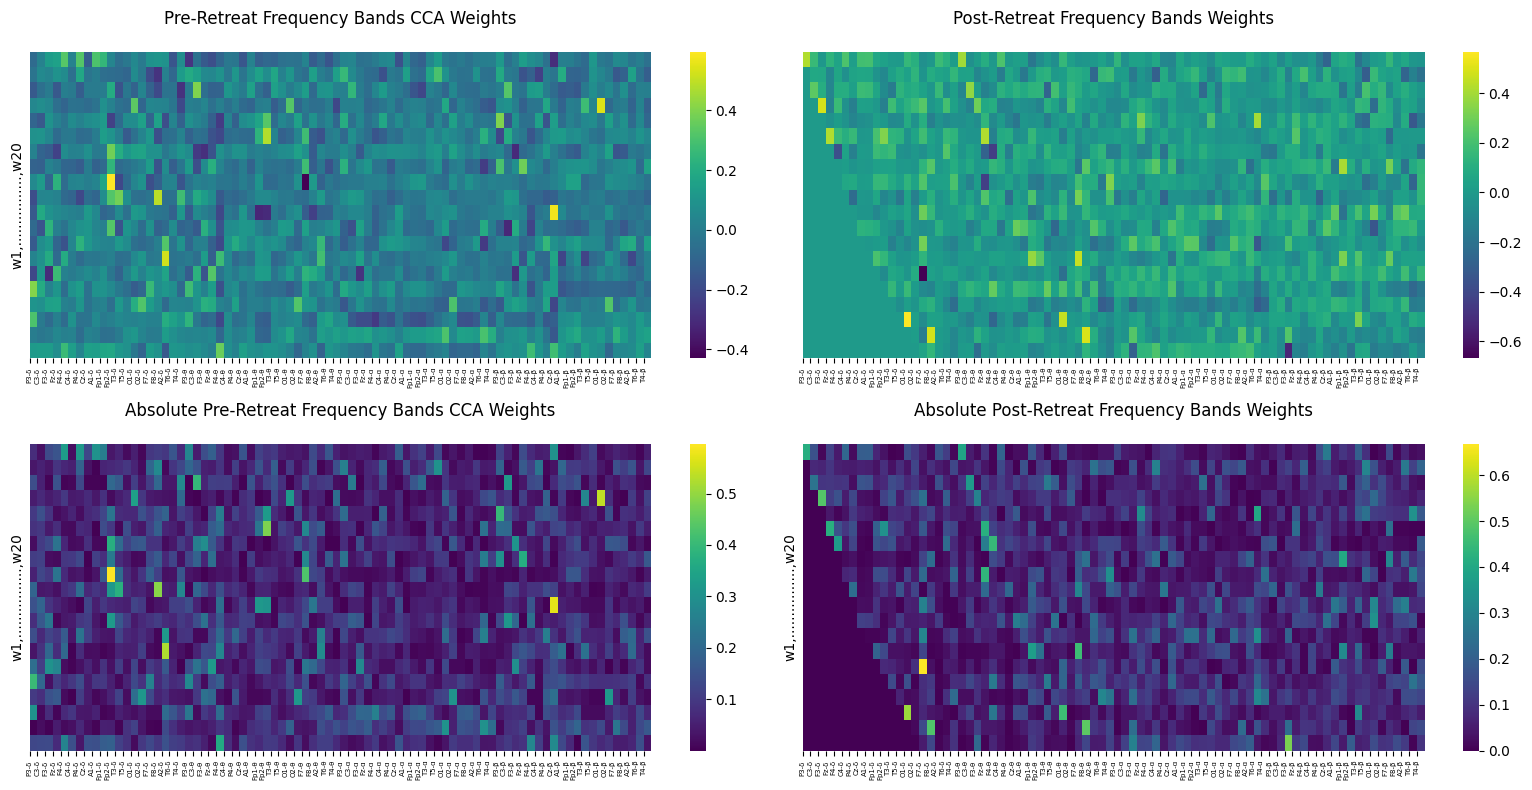

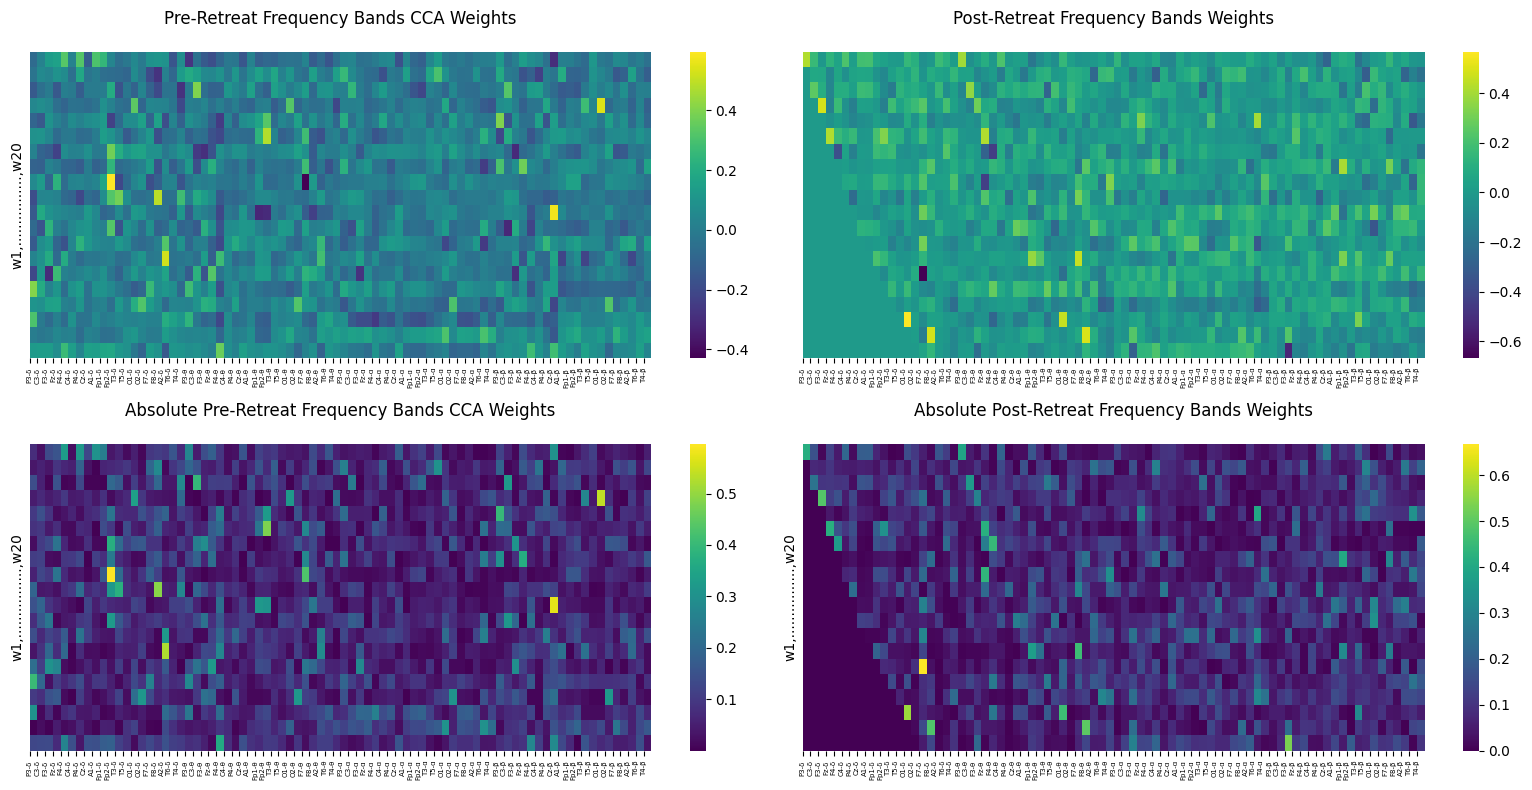

In [34]:
fig_, ax_ = plt.subplots(2, 2, figsize=(16,8))

sns.heatmap(bands_power_CCA.x_weights_.T, ax=ax_[0,0], cmap="viridis")
ax_[0,0].set_title("Pre-Retreat Frequency Bands CCA Weights", pad=20)
ax_[0,0].set_xticks(np.arange(X.shape[1]))
ax_[0,0].set_xticklabels(X.columns)
ax_[0,0].tick_params(axis='x', labelsize=5)
ax_[0,0].set_yticks([])
ax_[0,0].set_yticklabels([])
ax_[0,0].set_ylabel("w1,................,w20")

sns.heatmap(bands_power_CCA.y_weights_.T, ax=ax_[0,1], cmap="viridis")
ax_[0,1].set_title("Post-Retreat Frequency Bands Weights", pad=20)
ax_[0,1].set_xticks(np.arange(Y.shape[1]))
ax_[0,1].set_xticklabels(Y.columns)
ax_[0,1].tick_params(axis='x', labelsize=5)
ax_[0,1].set_yticks([])
ax_[0,1].set_yticklabels([])

sns.heatmap(abs(bands_power_CCA.x_weights_.T), ax=ax_[1,0], cmap="viridis")
ax_[1,0].set_title("Absolute Pre-Retreat Frequency Bands CCA Weights", pad=20)
ax_[1,0].set_xticks(np.arange(X.shape[1]))
ax_[1,0].set_xticklabels(X.columns)
ax_[1,0].tick_params(axis='x', labelsize=5)
ax_[1,0].set_yticks([])
ax_[1,0].set_yticklabels([])
ax_[1,0].set_ylabel("w1,................,w20")

sns.heatmap(abs(bands_power_CCA.y_weights_.T), ax=ax_[1,1], cmap="viridis")
ax_[1,1].set_title("Absolute Post-Retreat Frequency Bands Weights", pad=20)
ax_[1,1].set_xticks(np.arange(Y.shape[1]))
ax_[1,1].set_xticklabels(Y.columns)
ax_[1,1].tick_params(axis='x', labelsize=5)
ax_[1,1].set_yticks([])
ax_[1,1].set_yticklabels([])
ax_[1,1].set_ylabel("w1,................,w20")

fig_.tight_layout()
fig_

In [35]:
data_ = np.random.randn((20))
data_.shape

(20,)

In [36]:
coords = []
for ch in channels:
  coords.append(ten_twenty_coords[ch][:2])
coords = np.array(coords)

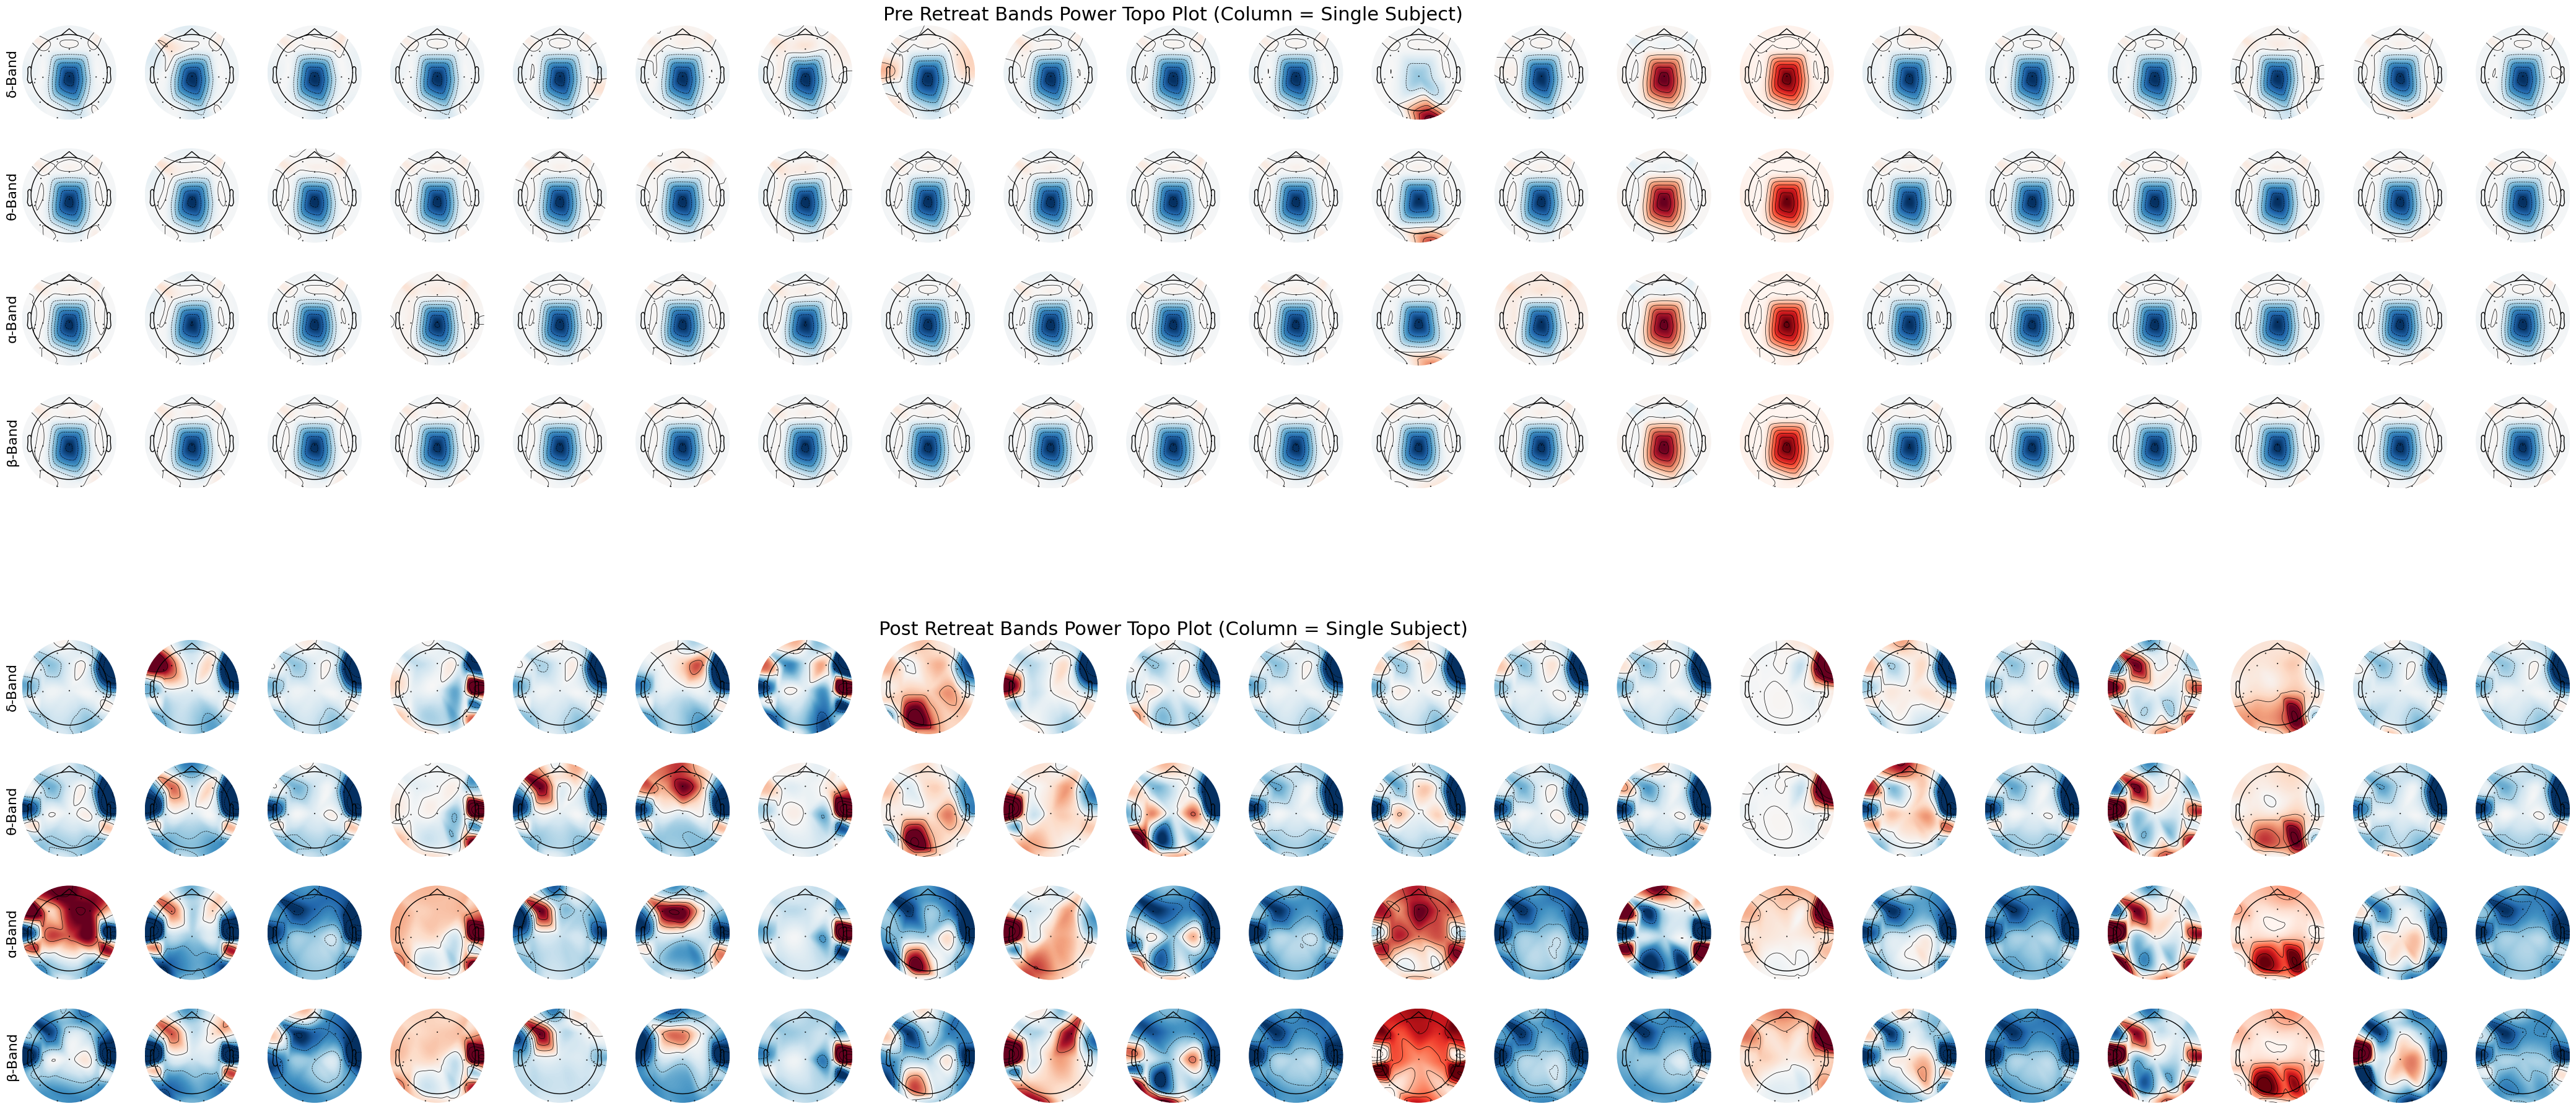

In [37]:
fig_, ax_ = plt.subplots(9, 21, figsize=(42,18))

for c in range(len(pre_retreat_bands_power)):
  mne.viz.plot_topomap(pre_retreat_bands_power.iloc[c,0:20], coords, axes=ax_[0,c], show=False)
  mne.viz.plot_topomap(pre_retreat_bands_power.iloc[c,20:40], coords, axes=ax_[1,c], show=False)
  mne.viz.plot_topomap(pre_retreat_bands_power.iloc[c,40:60], coords, axes=ax_[2,c], show=False)
  mne.viz.plot_topomap(pre_retreat_bands_power.iloc[c,60:80], coords, axes=ax_[3,c], show=False)

  ax_[4,c].set_visible(False)

  mne.viz.plot_topomap(post_retreat_bands_power.iloc[c,0:20], coords, axes=ax_[5,c], show=False)
  mne.viz.plot_topomap(post_retreat_bands_power.iloc[c,20:40], coords, axes=ax_[6,c], show=False)
  mne.viz.plot_topomap(post_retreat_bands_power.iloc[c,40:60], coords, axes=ax_[7,c], show=False)
  mne.viz.plot_topomap(post_retreat_bands_power.iloc[c,60:80], coords, axes=ax_[8,c], show=False)

bands = ["δ","θ","ɑ","β"]
for b in range(4):
  ax_[b,0].set_ylabel(bands[b]+"-Band", fontsize=16)
  ax_[5+b,0].set_ylabel(bands[b]+"-Band", fontsize=16)

ax_[0,9].set_title("Pre Retreat Bands Power Topo Plot (Column = Single Subject)", fontsize=22)
ax_[5,9].set_title("Post Retreat Bands Power Topo Plot (Column = Single Subject)", fontsize=22)

fig_.tight_layout()

plt.close("all")

fig_

### Coherence

In [39]:
def pair_coherence(sig1, sig2, fs):
  return np.mean(coherence(sig1, sig2, fs)[1])

def eeg_coherence(sig,fs):
  coherence_array = np.empty((sig.shape[0], sig.shape[0]))
  for i in range(sig.shape[0]):
    for j in range(sig.shape[0]):
      coherence_array[i,j] = pair_coherence(sig[i,::], sig[j,::], fs)
  return coherence_array

def eeg_band_coherence(signals, band, fs):
  band_signal = [mne.filter.filter_data(eeg,fs,band[0],band[1]) for eeg in signals]
  band_coherence = 0

  for s,s_eeg in enumerate(band_signal):
    band_coherence += eeg_coherence(s_eeg,fs)
  band_coherence /= len(band_signal)

  return band_coherence

In [40]:
min_max = lambda x: (x-x.min())/(x.max()-x.min())

In [49]:
delta_pre_retreat_coherence = eeg_band_coherence(preretreat, delta, fs)
theta_pre_retreat_coherence = eeg_band_coherence(preretreat, theta, fs)
alpha_pre_retreat_coherence = eeg_band_coherence(preretreat, alpha, fs)
beta_pre_retreat_coherence = eeg_band_coherence(preretreat, beta, fs)

delta_post_retreat_coherence = eeg_band_coherence(postretreat, delta, fs)
theta_post_retreat_coherence = eeg_band_coherence(postretreat, theta, fs)
alpha_post_retreat_coherence = eeg_band_coherence(postretreat, alpha, fs)
beta_post_retreat_coherence = eeg_band_coherence(postretreat, beta, fs)

In [112]:
delta_min = min(delta_pre_retreat_coherence.min(),delta_post_retreat_coherence.min())
theta_min = min(theta_pre_retreat_coherence.min(),theta_post_retreat_coherence.min())
alpha_min = min(alpha_pre_retreat_coherence.min(),alpha_post_retreat_coherence.min())
beta_min = min(beta_pre_retreat_coherence.min(),beta_post_retreat_coherence.min())

delta_max = max(delta_pre_retreat_coherence.max(),delta_post_retreat_coherence.max())
theta_max = max(theta_pre_retreat_coherence.max(),theta_post_retreat_coherence.max())
alpha_max = max(alpha_pre_retreat_coherence.max(),alpha_post_retreat_coherence.max())
beta_max = max(beta_pre_retreat_coherence.max(),beta_post_retreat_coherence.max())

_min = min([delta_min, theta_min, alpha_min, beta_min])
_max = max([delta_max, theta_max, alpha_max, beta_max])

delta_pre_retreat_coherence_ = (delta_pre_retreat_coherence-_min)/(_max-_min)
theta_pre_retreat_coherence_ = (theta_pre_retreat_coherence-_min)/(_max-_min)
alpha_pre_retreat_coherence_ = (alpha_pre_retreat_coherence-_min)/(_max-_min)
beta_pre_retreat_coherence_ = (beta_pre_retreat_coherence-_min)/(_max-_min)

delta_post_retreat_coherence_ = (delta_post_retreat_coherence-_min)/(_max-_min)
theta_post_retreat_coherence_ = (theta_post_retreat_coherence-_min)/(_max-_min)
alpha_post_retreat_coherence_ = (alpha_post_retreat_coherence-_min)/(_max-_min)
beta_post_retreat_coherence_ = (beta_post_retreat_coherence-_min)/(_max-_min)


threshold = 0.25

delta_pre_retreat_coherence_[delta_pre_retreat_coherence_<threshold] = threshold
theta_pre_retreat_coherence_[theta_pre_retreat_coherence_<threshold] = threshold
alpha_pre_retreat_coherence_[alpha_pre_retreat_coherence_<threshold] = threshold
beta_pre_retreat_coherence_[beta_pre_retreat_coherence_<threshold] = threshold

delta_post_retreat_coherence_[delta_post_retreat_coherence_<threshold] = threshold
theta_post_retreat_coherence_[theta_post_retreat_coherence_<threshold] = threshold
alpha_post_retreat_coherence_[alpha_post_retreat_coherence_<threshold] = threshold
beta_post_retreat_coherence_[beta_post_retreat_coherence_<threshold] = threshold

delta_pre_retreat_coherence_ = min_max(delta_pre_retreat_coherence_)
theta_pre_retreat_coherence_ = min_max(theta_pre_retreat_coherence_)
alpha_pre_retreat_coherence_ = min_max(alpha_pre_retreat_coherence_)
beta_pre_retreat_coherence_ = min_max(beta_pre_retreat_coherence_)

delta_post_retreat_coherence_ = min_max(delta_post_retreat_coherence_)
theta_post_retreat_coherence_ = min_max(theta_post_retreat_coherence_)
alpha_post_retreat_coherence_ = min_max(alpha_post_retreat_coherence_)
beta_post_retreat_coherence_ = min_max(beta_post_retreat_coherence_)

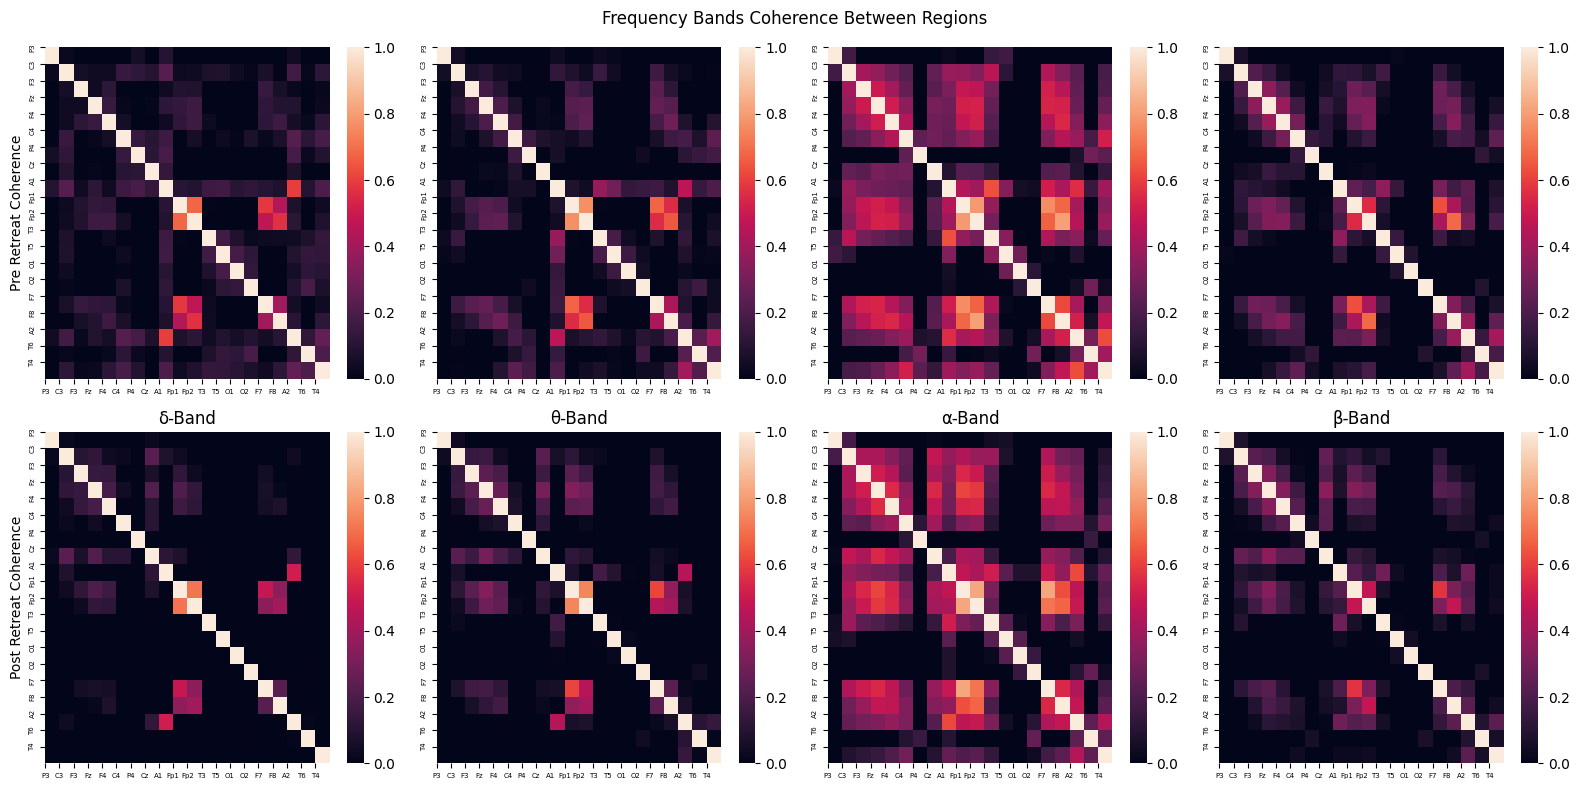

In [113]:
plt.close("all")
fig_, ax_ = plt.subplots(2, 4, figsize=(16,8))

sns.heatmap(delta_pre_retreat_coherence_, ax=ax_[0,0])
sns.heatmap(theta_pre_retreat_coherence_, ax=ax_[0,1])
sns.heatmap(alpha_pre_retreat_coherence_, ax=ax_[0,2])
sns.heatmap(beta_pre_retreat_coherence_, ax=ax_[0,3])

sns.heatmap(delta_post_retreat_coherence_, ax=ax_[1,0])
sns.heatmap(theta_post_retreat_coherence_, ax=ax_[1,1])
sns.heatmap(alpha_post_retreat_coherence_, ax=ax_[1,2])
sns.heatmap(beta_post_retreat_coherence_, ax=ax_[1,3])

ax_[1,0].set_title("δ-Band")
ax_[1,1].set_title("θ-Band")
ax_[1,2].set_title("α-Band")
ax_[1,3].set_title("β-Band")

ax_[0,0].set_ylabel("Pre Retreat Coherence")
ax_[1,0].set_ylabel("Post Retreat Coherence")

for c in range(4):
  ax_[0,c].set_xticks(np.arange(delta_pre_retreat_coherence.shape[0]))
  ax_[0,c].set_xticklabels(channels)
  ax_[0,c].tick_params(axis='x', labelsize=5)
  ax_[0,c].set_yticks(np.arange(delta_pre_retreat_coherence.shape[0]))
  ax_[0,c].set_yticklabels(channels)
  ax_[0,c].tick_params(axis='y', labelsize=5)

  ax_[1,c].set_yticks(np.arange(delta_pre_retreat_coherence.shape[0]))
  ax_[1,c].set_yticklabels(channels)
  ax_[1,c].tick_params(axis='y', labelsize=5)
  ax_[1,c].set_xticks(np.arange(delta_pre_retreat_coherence.shape[0]))
  ax_[1,c].set_xticklabels(channels)
  ax_[1,c].tick_params(axis='x', labelsize=5)

fig_.suptitle("Frequency Bands Coherence Between Regions")

fig_.tight_layout()
fig_

In [114]:
delta_min = min(delta_pre_retreat_coherence.min(),delta_post_retreat_coherence.min())
theta_min = min(theta_pre_retreat_coherence.min(),theta_post_retreat_coherence.min())
alpha_min = min(alpha_pre_retreat_coherence.min(),alpha_post_retreat_coherence.min())
beta_min = min(beta_pre_retreat_coherence.min(),beta_post_retreat_coherence.min())

delta_max = max(delta_pre_retreat_coherence.max(),delta_post_retreat_coherence.max())
theta_max = max(theta_pre_retreat_coherence.max(),theta_post_retreat_coherence.max())
alpha_max = max(alpha_pre_retreat_coherence.max(),alpha_post_retreat_coherence.max())
beta_max = max(beta_pre_retreat_coherence.max(),beta_post_retreat_coherence.max())

_min = min([delta_min, theta_min, alpha_min, beta_min])
_max = max([delta_max, theta_max, alpha_max, beta_max])

delta_pre_retreat_coherence_ = (delta_pre_retreat_coherence-_min)/(_max-_min)
theta_pre_retreat_coherence_ = (theta_pre_retreat_coherence-_min)/(_max-_min)
alpha_pre_retreat_coherence_ = (alpha_pre_retreat_coherence-_min)/(_max-_min)
beta_pre_retreat_coherence_ = (beta_pre_retreat_coherence-_min)/(_max-_min)

delta_post_retreat_coherence_ = (delta_post_retreat_coherence-_min)/(_max-_min)
theta_post_retreat_coherence_ = (theta_post_retreat_coherence-_min)/(_max-_min)
alpha_post_retreat_coherence_ = (alpha_post_retreat_coherence-_min)/(_max-_min)
beta_post_retreat_coherence_ = (beta_post_retreat_coherence-_min)/(_max-_min)


threshold = 0.3

delta_pre_retreat_coherence_[delta_pre_retreat_coherence_<threshold] = threshold
theta_pre_retreat_coherence_[theta_pre_retreat_coherence_<threshold] = threshold
alpha_pre_retreat_coherence_[alpha_pre_retreat_coherence_<threshold] = threshold
beta_pre_retreat_coherence_[beta_pre_retreat_coherence_<threshold] = threshold

delta_post_retreat_coherence_[delta_post_retreat_coherence_<threshold] = threshold
theta_post_retreat_coherence_[theta_post_retreat_coherence_<threshold] = threshold
alpha_post_retreat_coherence_[alpha_post_retreat_coherence_<threshold] = threshold
beta_post_retreat_coherence_[beta_post_retreat_coherence_<threshold] = threshold

delta_pre_retreat_coherence_ = min_max(delta_pre_retreat_coherence_)
theta_pre_retreat_coherence_ = min_max(theta_pre_retreat_coherence_)
alpha_pre_retreat_coherence_ = min_max(alpha_pre_retreat_coherence_)
beta_pre_retreat_coherence_ = min_max(beta_pre_retreat_coherence_)

delta_post_retreat_coherence_ = min_max(delta_post_retreat_coherence_)
theta_post_retreat_coherence_ = min_max(theta_post_retreat_coherence_)
alpha_post_retreat_coherence_ = min_max(alpha_post_retreat_coherence_)
beta_post_retreat_coherence_ = min_max(beta_post_retreat_coherence_)

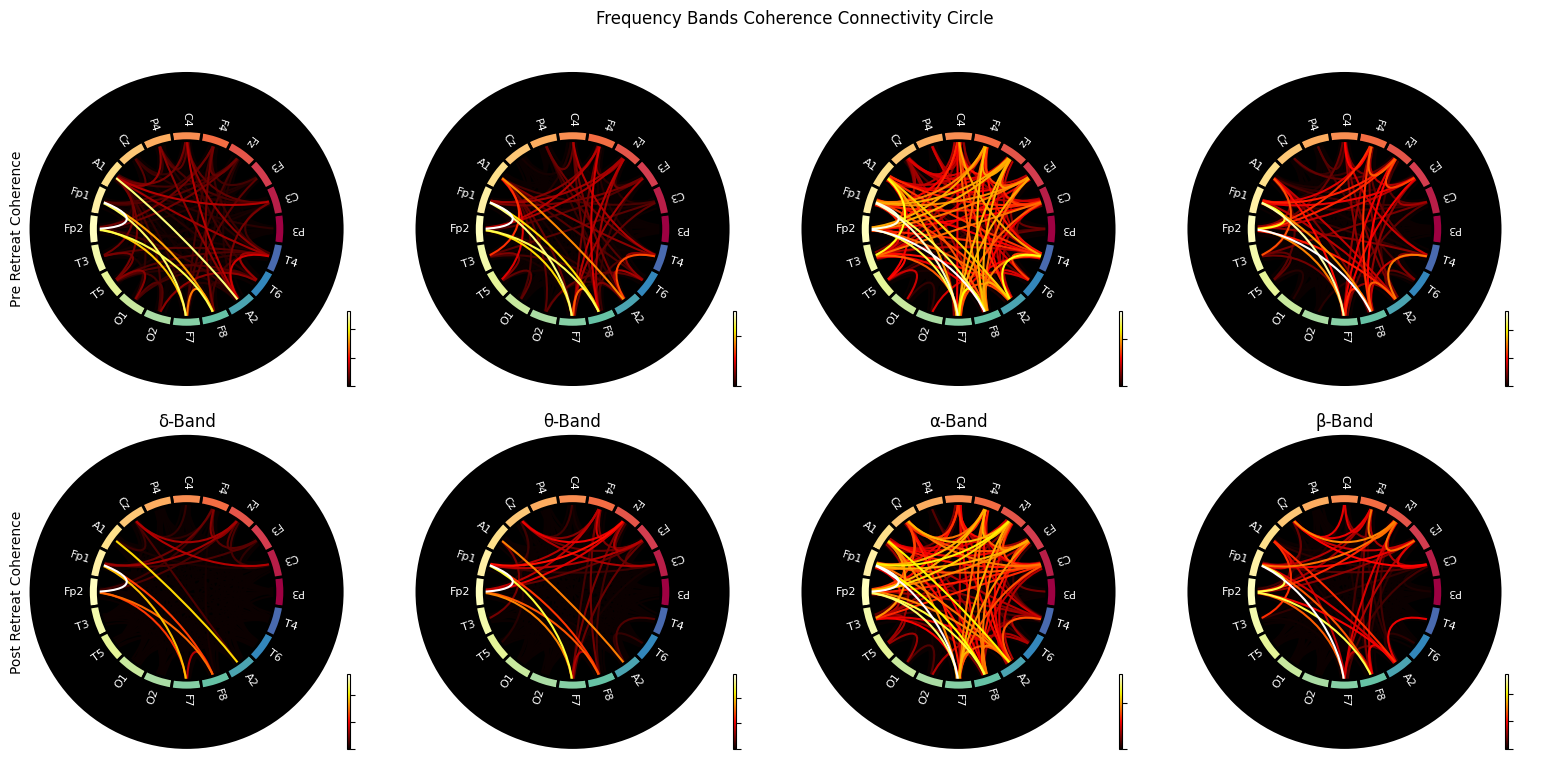

In [115]:
plt.close("all")
plt.ioff()
fig_, ax_ = plt.subplots(2, 4, figsize=(16,8), subplot_kw={'projection': 'polar'})

mne_connectivity.viz.plot_connectivity_circle(delta_pre_retreat_coherence_,channels,ax=ax_[0,0],show=False)
mne_connectivity.viz.plot_connectivity_circle(theta_pre_retreat_coherence_,channels,ax=ax_[0,1],show=False)
mne_connectivity.viz.plot_connectivity_circle(alpha_pre_retreat_coherence_,channels,ax=ax_[0,2],show=False)
mne_connectivity.viz.plot_connectivity_circle(beta_pre_retreat_coherence_,channels,ax=ax_[0,3],show=False)

mne_connectivity.viz.plot_connectivity_circle(delta_post_retreat_coherence_,channels,ax=ax_[1,0],show=False)
mne_connectivity.viz.plot_connectivity_circle(theta_post_retreat_coherence_,channels,ax=ax_[1,1],show=False)
mne_connectivity.viz.plot_connectivity_circle(alpha_post_retreat_coherence_,channels,ax=ax_[1,2],show=False)
mne_connectivity.viz.plot_connectivity_circle(beta_post_retreat_coherence_,channels,ax=ax_[1,3],show=False)

ax_[1,0].set_title("δ-Band")
ax_[1,1].set_title("θ-Band")
ax_[1,2].set_title("α-Band")
ax_[1,3].set_title("β-Band")

ax_[0,0].set_ylabel("Pre Retreat Coherence")
ax_[1,0].set_ylabel("Post Retreat Coherence")

fig_.suptitle("Frequency Bands Coherence Connectivity Circle")
fig_.tight_layout()
fig_

### STFT

In [134]:
preretreat_stft = []
postretreat_stft = []

wsize_ = 8
tstep_ = 4

for pre_data, post_data in zip(preretreat,postretreat):
  preretreat_stft.append(mne.time_frequency.stft(pre_data, wsize_, tstep_, verbose=None))
  postretreat_stft.append(mne.time_frequency.stft(post_data, wsize_, tstep_, verbose=None))

In [138]:
def cosine_similarity(A, B):
  dot_product = np.dot(A, B)
  norm_A = np.linalg.norm(A)
  norm_B = np.linalg.norm(B)
  return 1-dot_product / (norm_A * norm_B)

In [147]:
pre_pre_RDM = np.zeros((len(preretreat_stft), len(postretreat_stft)))
post_post_RDM = np.zeros((len(preretreat_stft), len(postretreat_stft)))
pre_post_RDM = np.zeros((len(preretreat_stft), len(postretreat_stft)))

for i, A in enumerate(preretreat_stft):
  for j, B in enumerate(preretreat_stft):
    pre_pre_RDM[i,j] = abs(cosine_similarity(A.flatten(),B.flatten()))

for i, A in enumerate(postretreat_stft):
  for j, B in enumerate(postretreat_stft):
    post_post_RDM[i,j] = abs(cosine_similarity(A.flatten(),B.flatten()))

for i, A in enumerate(preretreat_stft):
  for j, B in enumerate(postretreat_stft):
    pre_post_RDM[i,j] = abs(cosine_similarity(A.flatten(),B.flatten()))

In [148]:
min_ = min([pre_pre_RDM.min(), post_post_RDM.min(), pre_post_RDM.min()])
max_ = min([pre_pre_RDM.max(), post_post_RDM.max(), pre_post_RDM.max()])

pre_pre_RDM_ = (pre_pre_RDM - min_)/(max_ - min_)
post_post_RDM_ = (post_post_RDM - min_)/(max_ - min_)
pre_post_RDM_ = (pre_post_RDM - min_)/(max_ - min_)

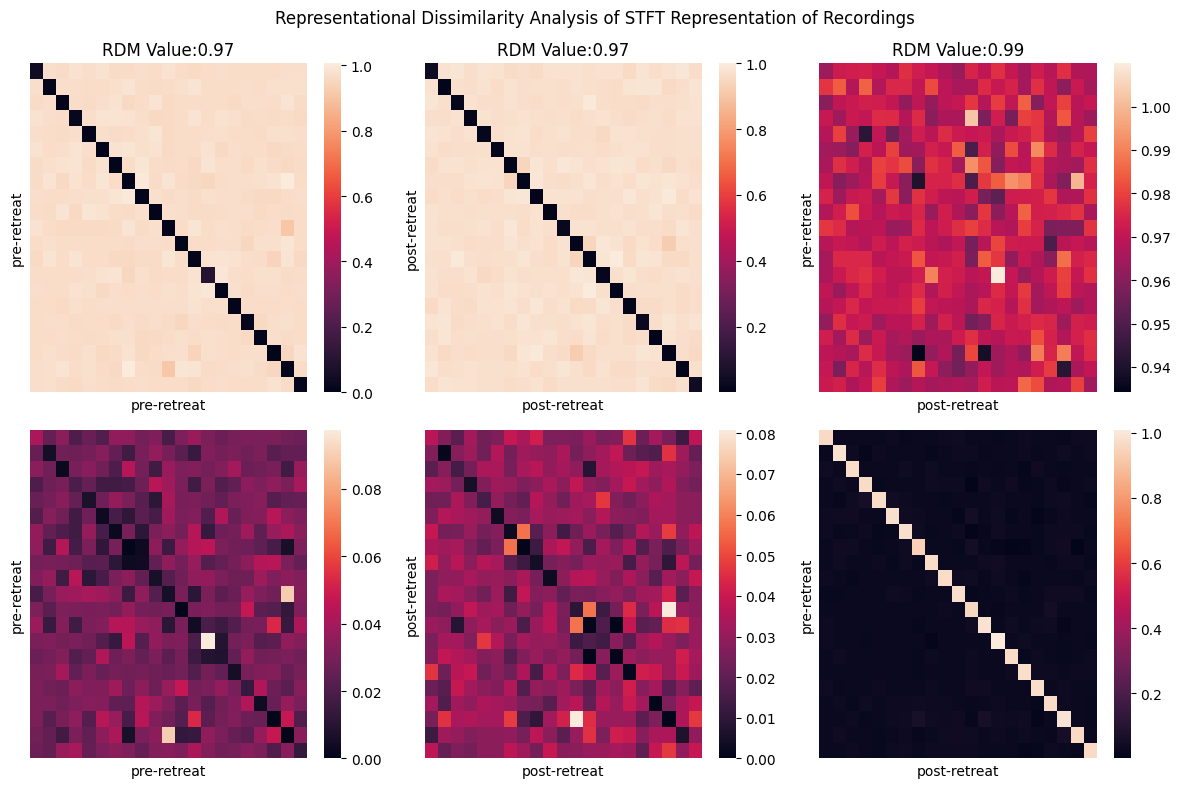

In [162]:
plt.close("all")
fig_, ax_ = plt.subplots(2,3,figsize=(12,8))

perfect_RDM = 1-np.diag(np.ones(21))
perfect_RDM_value = np.linalg.norm(1-np.diag(np.ones(21)))


sns.heatmap(pre_pre_RDM_, ax=ax_[0,0])
sns.heatmap(post_post_RDM_, ax=ax_[0,1])
sns.heatmap(pre_post_RDM_, ax=ax_[0,2])

sns.heatmap(abs(perfect_RDM-pre_pre_RDM_), ax=ax_[1,0])
sns.heatmap(abs(perfect_RDM-post_post_RDM_), ax=ax_[1,1])
sns.heatmap(abs(perfect_RDM-pre_post_RDM_), ax=ax_[1,2])

ax_[0,0].set_xlabel("pre-retreat")
ax_[0,0].set_ylabel("pre-retreat")
ax_[0,0].set_title(f"RDM Value:{round(np.linalg.norm(pre_pre_RDM_/perfect_RDM_value),2)}")

ax_[0,1].set_xlabel("post-retreat")
ax_[0,1].set_ylabel("post-retreat")
ax_[0,1].set_title(f"RDM Value:{round(np.linalg.norm(post_post_RDM_/perfect_RDM_value),2)}")

ax_[0,2].set_xlabel("post-retreat")
ax_[0,2].set_ylabel("pre-retreat")
ax_[0,2].set_title(f"RDM Value:{round(np.linalg.norm(pre_post_RDM_/perfect_RDM_value),2)}")

for ax in ax_.flatten():
  ax.set_xticks([])
  ax.set_xticklabels([])
  ax.set_yticks([])
  ax.set_yticklabels([])

ax_[1,0].set_xlabel("pre-retreat")
ax_[1,0].set_ylabel("pre-retreat")

ax_[1,1].set_xlabel("post-retreat")
ax_[1,1].set_ylabel("post-retreat")

ax_[1,2].set_xlabel("post-retreat")
ax_[1,2].set_ylabel("pre-retreat")

fig_.suptitle("Representational Dissimilarity Analysis of STFT Representation of Recordings")
fig_.tight_layout()
fig_